In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import sys
import json
import time
import rich
import numpy as np
import pickle
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from configs.finetune import FinetuneConfig
from tasks.classification import Classification

from models.backbone.base import calculate_out_features
from models.backbone.densenet import DenseNetBackbone
from models.backbone.resnet import build_resnet_backbone
from models.head.projector import MLPHead
from models.head.classifier import LinearClassifier

from datasets.brain import BrainProcessor, Brain, BrainMoCo
from datasets.transforms import make_transforms, compute_statistics

from utils.logging import get_rich_logger
from utils.gpu import set_gpu

from easydict import EasyDict as edict
from torch.utils.data import DataLoader

In [3]:
hashs = ["2022-07-09_19-50-10"]

In [8]:
hash = hashs[0]

In [11]:
finetune_dir = f'../checkpoints/pet/densenet/{hash}'

In [12]:
config = os.path.join(finetune_dir, 'configs.json')
with open(config, 'rb') as fb:
    config = json.load(fb)
    config = edict(config)

In [14]:
config.server = 'workstation2'
config.gpus = ['01']
local_rank = 0
set_gpu(config)

In [15]:
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True

torch.cuda.set_device(local_rank)

# Networks
if config.backbone_type == 'densenet':
    backbone = DenseNetBackbone(in_channels=1,
                                init_features=config.init_features,
                                growth_rate=config.growth_rate,
                                block_config=config.block_config,
                                bn_size=config.bn_size,
                                dropout_rate=config.dropout_rate,
                                semi=False)
    activation = True
elif config.backbone_type == 'resnet':
    backbone = build_resnet_backbone(arch=config.arch,
                                     no_max_pool=config.no_max_pool,
                                     in_channels=1,
                                     semi=False)
    activation = False
if config.small_kernel:
    backbone._fix_first_conv()
if config.crop:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.crop_size)
else:
    out_dim = calculate_out_features(backbone=backbone, in_channels=1, image_size=config.image_size)
classifier = LinearClassifier(in_channels=out_dim, num_classes=2, activation=activation)

backbone.load_weights_from_checkpoint(os.path.join(finetune_dir, "ckpt.last.pth.tar"), key='backbone')
classifier.load_weights_from_checkpoint(os.path.join(finetune_dir, "ckpt.last.pth.tar"), key='classifier')

In [16]:
# load finetune data
data_processor = BrainProcessor(root=config.root,
                                data_info=config.data_info,
                                data_type=config.data_type,
                                mci_only=config.mci_only,
                                random_state=config.random_state)
datasets = data_processor.process(n_splits=config.n_splits, n_cv=config.n_cv)

# intensity normalization
assert config.intensity in [None, 'scale', 'minmax']
mean_std, min_max = (None, None), (None, None)
if config.intensity is None:
    pass
elif config.intensity == 'scale':
    pass
elif config.intensity == 'minmax':
    with open(os.path.join(config.root, 'labels/minmax.pkl'), 'rb') as fb:
        minmax_stats = pickle.load(fb)
        min_max = (minmax_stats[config.data_type]['min'], minmax_stats[config.data_type]['max'])
else:
    raise NotImplementedError

train_transform, test_transform = make_transforms(image_size=config.image_size,
                                                  intensity=config.intensity,
                                                  mean_std=mean_std,
                                                  min_max=min_max,
                                                  crop=config.crop,
                                                  crop_size=config.crop_size,
                                                  rotate=config.rotate,
                                                  flip=config.flip,
                                                  affine=config.affine,
                                                  blur=config.blur,
                                                  blur_std=config.blur_std,
                                                  prob=config.prob)

train_set = Brain(dataset=datasets['train'], data_type=config.data_type, transform=test_transform)
test_set = Brain(dataset=datasets['test'], data_type=config.data_type, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=16, drop_last=False)
test_loader = DataLoader(dataset=test_set, batch_size=16, drop_last=False)

In [17]:
from monai.visualize import CAM, GradCAM

In [18]:
class ModelViz(nn.Module):
    def __init__(self, local_rank):
        super(ModelViz, self).__init__()
        self.local_rank = local_rank
    
    def _build_model(self, backbone, classifier):
    
        self.backbone = backbone
        self.classifier = classifier
        
        self.backbone.to(self.local_rank)
        self.classifier.to(self.local_rank)
        self.backbone.eval()
        self.classifier.eval()
    def forward(self, x):
        logits = self.classifier(self.backbone(x))
        return logits

In [19]:
model = ModelViz(local_rank)
model._build_model(backbone, classifier)

In [26]:
gradcam = GradCAM(nn_module=model, target_layers='backbone.features.denseblock4.denselayer16')

In [27]:
for batch in train_loader:
    gradcam_result = gradcam(batch['x'].to(local_rank))
    break

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

print(batch['y'])

tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0])


------------------------ 0 ----------------------------


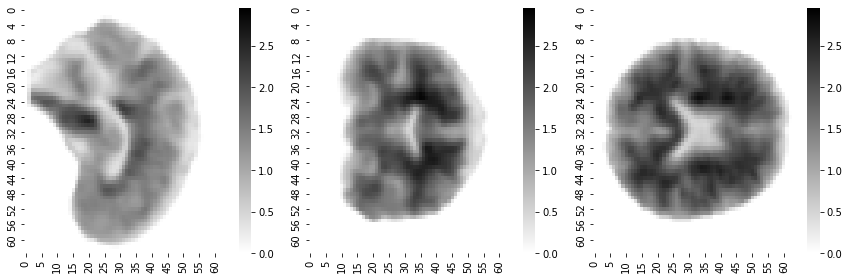

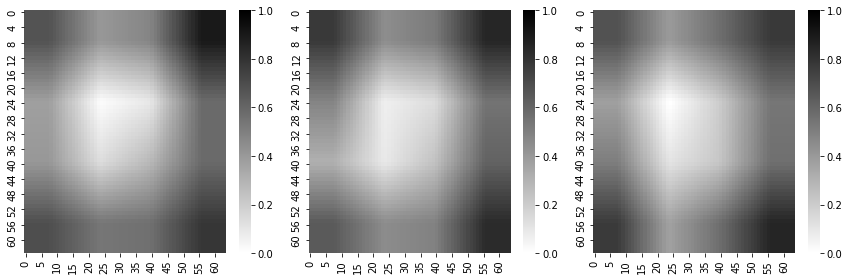

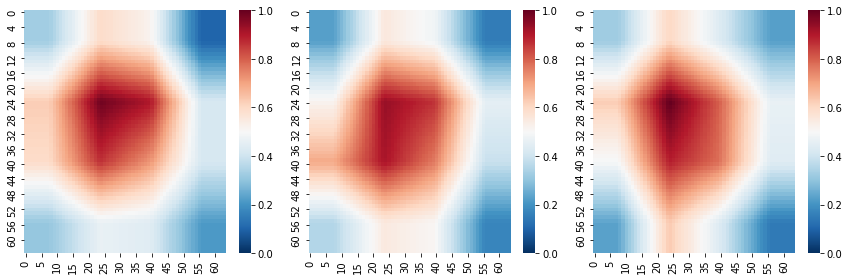

------------------------ 2 ----------------------------


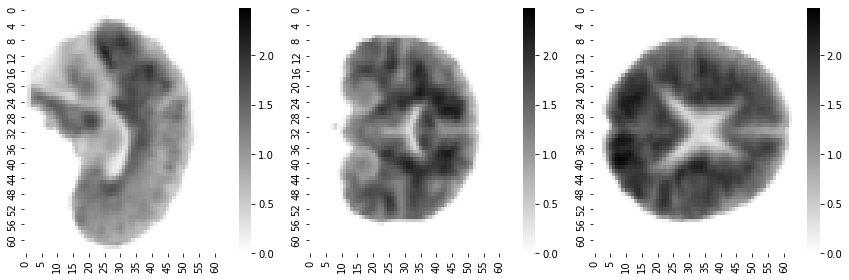

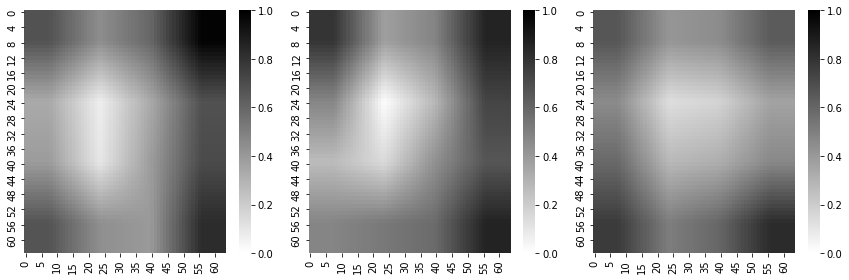

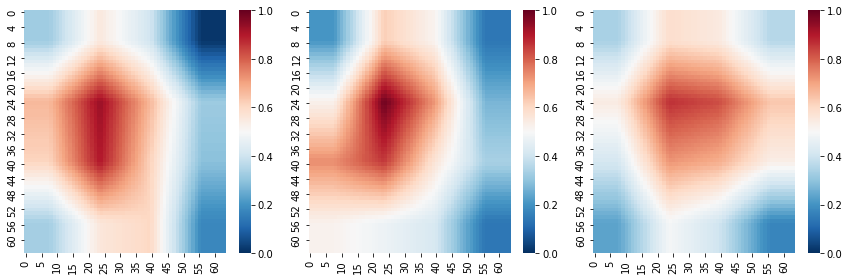

------------------------ 4 ----------------------------


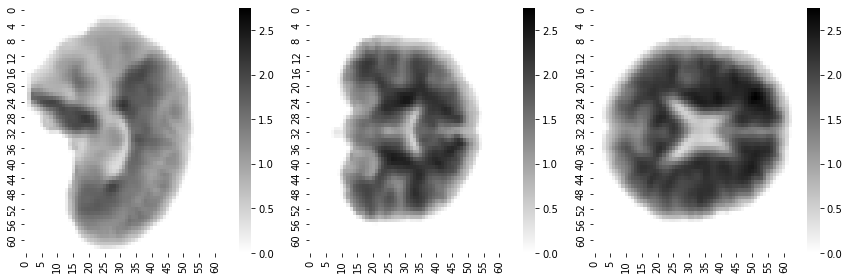

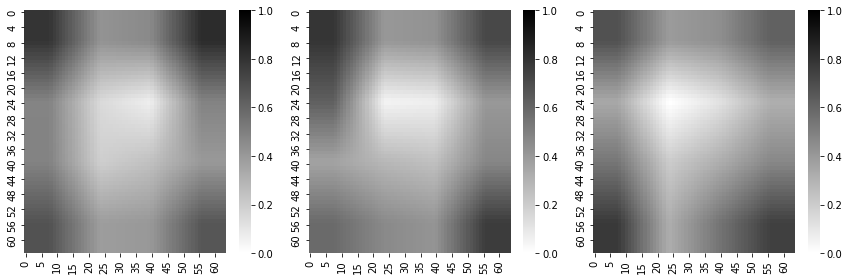

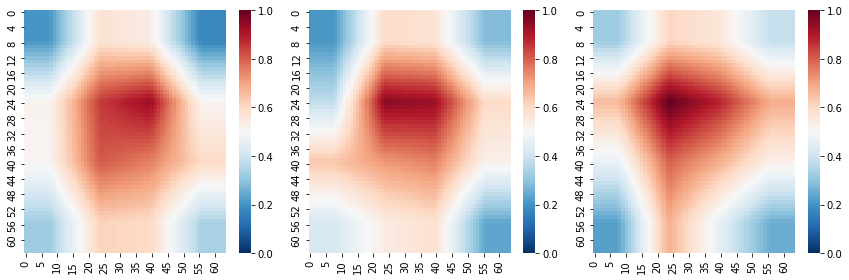

In [35]:
for idx in [0, 2, 4]:
    print('------------------------', idx, '----------------------------')
    image = batch['x'][idx][0].numpy()

    ##
    vmax = image.max()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs = axs.ravel()
    sns.heatmap(image[32, :, :], vmin=0, vmax=vmax, ax=axs[0], cmap='binary')
    sns.heatmap(image[:, 32, :], vmin=0, vmax=vmax, ax=axs[1], cmap='binary')
    sns.heatmap(image[:, :, 32], vmin=0, vmax=vmax, ax=axs[2], cmap='binary')
    plt.tight_layout()
    plt.show()

    ##
    viz_grad = gradcam_result[idx][0].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs = axs.ravel()
    sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=1, cmap='binary')
    sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=1, cmap='binary')
    sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=1, cmap='binary')
    plt.tight_layout()
    plt.show()

    ##
    viz_grad = np.abs(viz_grad - 1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs = axs.ravel()
    sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=1, cmap='RdBu_r')
    sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=1, cmap='RdBu_r')
    sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=1, cmap='RdBu_r')
    plt.tight_layout()
    plt.show()

------------------------ 1 ----------------------------


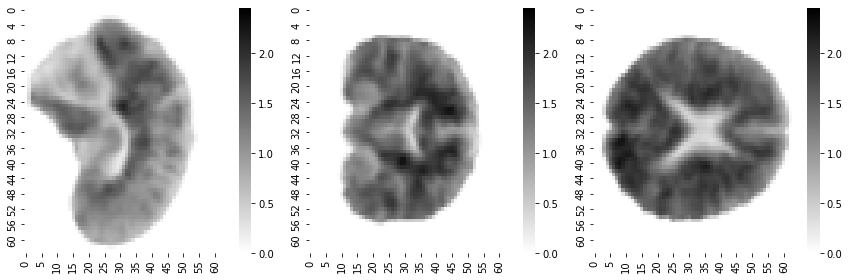

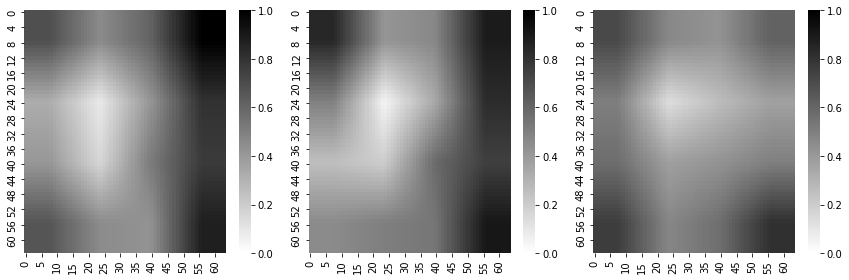

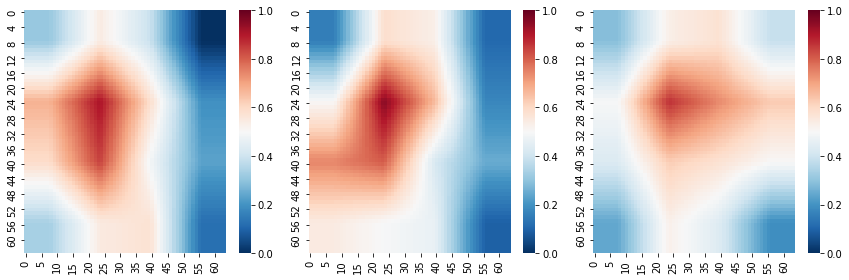

------------------------ 3 ----------------------------


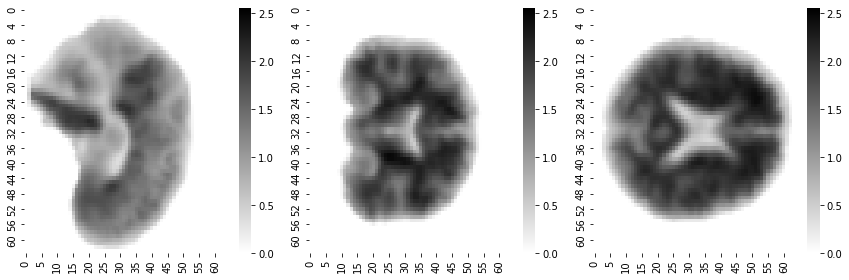

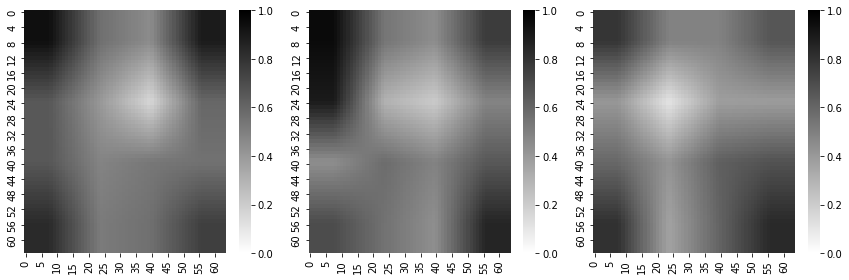

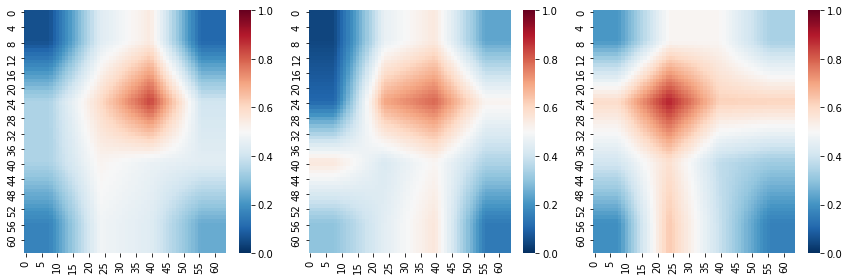

In [36]:
for idx in [1, 3]:
    print('------------------------', idx, '----------------------------')
    image = batch['x'][idx][0].numpy()

    ##
    vmax = image.max()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs = axs.ravel()
    sns.heatmap(image[32, :, :], vmin=0, vmax=vmax, ax=axs[0], cmap='binary')
    sns.heatmap(image[:, 32, :], vmin=0, vmax=vmax, ax=axs[1], cmap='binary')
    sns.heatmap(image[:, :, 32], vmin=0, vmax=vmax, ax=axs[2], cmap='binary')
    plt.tight_layout()
    plt.show()

    ##
    viz_grad = gradcam_result[idx][0].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs = axs.ravel()
    sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=1, cmap='binary')
    sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=1, cmap='binary')
    sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=1, cmap='binary')
    plt.tight_layout()
    plt.show()

    ##
    viz_grad = np.abs(viz_grad - 1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs = axs.ravel()
    sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=1, cmap='RdBu_r')
    sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=1, cmap='RdBu_r')
    sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=1, cmap='RdBu_r')
    plt.tight_layout()
    plt.show()

# class-wise average

In [47]:
result_list = []
y_list = []


# TODO: filter only correctly-classified ones
for batch in tqdm.tqdm(train_loader):
    x = batch['x'].to(local_rank)
    gradcam_result = gradcam(x)
    gradcam_result = gradcam_result.cpu().numpy()
    y = batch['y'].cpu().numpy()
    
    result_list.append(gradcam_result)
    y_list.append(y)

100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


In [48]:
result_list = np.concatenate(result_list)

In [49]:
y_list = np.concatenate(y_list)

In [51]:
nconv, conv = np.where(y_list == 0)[0], np.where(y_list == 1)[0]

In [52]:
nconv = result_list[nconv]
conv = result_list[conv]

In [53]:
nconv = np.mean(nconv, 0)
conv = np.mean(conv, 0)

In [56]:
nconv = nconv[0]
conv = conv[0]

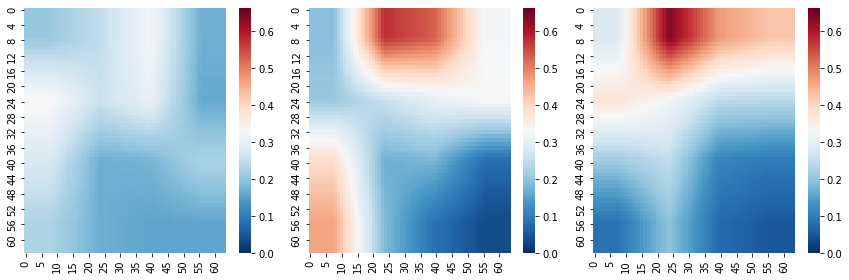

In [61]:
viz_grad = np.abs(nconv - 1)
vmax = viz_grad.max()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()
sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=vmax, cmap='RdBu_r')
sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=vmax, cmap='RdBu_r')
sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=vmax, cmap='RdBu_r')
plt.tight_layout()
plt.show()

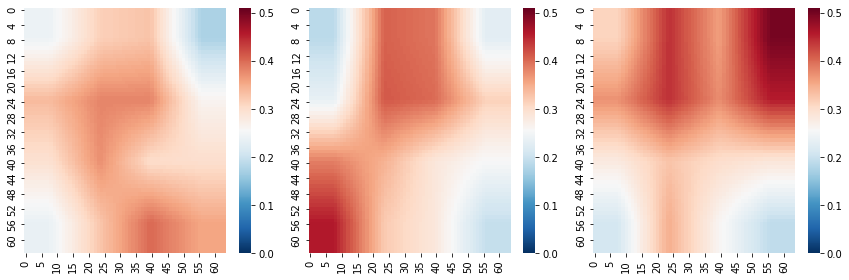

In [62]:
viz_grad = np.abs(conv - 1)
vmax = viz_grad.max()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.ravel()
sns.heatmap(viz_grad[32, :, :], ax=axs[0], vmin=0, vmax=vmax, cmap='RdBu_r')
sns.heatmap(viz_grad[:, 32, :], ax=axs[1], vmin=0, vmax=vmax, cmap='RdBu_r')
sns.heatmap(viz_grad[:, :, 32], ax=axs[2], vmin=0, vmax=vmax, cmap='RdBu_r')
plt.tight_layout()
plt.show()